# NLP on Dataquest's guided project feedback

Dataquest offers online, project-based data science courses focused on data analysis using R and Python. Part of every course is a hands on project to practice your skills in real world applications. After finishing your project, the platform encourages you to publish it on their forum to gather feedback. 

I've benefited a lot from various people sharing their insights on my work. As I've progressed, I've started giving back and showing other people what I would have done differently in their projects. This led me to this project. In this notebook I'll gather the data from all the feedback posts, clean it and analyze it. That should give us an insight on the most common remarks regarding our published projects. After the analysis step, we'll try to train a few machine learning models on recognizing the feedback content and classifying it.

links:

* [NLP article](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a)
* [text processing function](https://github.com/rohithramesh1991/Text-Preprocessing/blob/master/Text%20Preprocessing_codes.py)
* [my list of popular feedback remarks](https://github.com/grumpyclimber/portfolio/blob/main/nlp_feedback/feedback.md)
* [dataset](https://github.com/grumpyclimber/portfolio/blob/main/nlp_feedback/dq.csv)
* [project on GitHub](https://github.com/grumpyclimber/portfolio/tree/main/nlp_feedback)
* [my LinkedIn](https://www.linkedin.com/in/adam-kubalica-787a79220/)
* [my GitHub](https://github.com/grumpyclimber/portfolio)

<a id='index'></a>


Index:
1. [Scraping the main thread](#main)
2. [Scraping the individual posts](#post)
3. [Text analysis](#text)
4. [Supervised machine learning](#ml)
5. [Kmeans clustering](#cluster)
6. [Conclusions](#conclusions)

In [1]:
# lets start with importing all the packages and libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bs4
from bs4 import BeautifulSoup
import requests
import urllib
import urllib.request
from urllib.request import urlopen, Request
import codecs
# from textblob import TextBlob, Word, Blobber
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id='main'></a>

# 1. Scraping the main thread for links of all the published projects:
[back to top](#index)

We'll start with scraping the dataquests forum page for publishing projects, every thread on that page represents a different project. We're interested in the content of those threads. To get to that content, we need to obtain links to that content. So we have to scrape the guided project page containing all those threads, then scrape all the posts individually.

In [2]:
# step 1 lets scrape the guided project website with all the posts:
url = "https://community.dataquest.io/c/share/guided-project/55"
html = urlopen(url)
soup = BeautifulSoup(html, 'lxml')
list_all = soup.find_all("a", class_="title raw-link raw-topic-link")
len(list_all)

30

### Example of scraped link (before text cleaning):

In [3]:
list_all[3]

<a class="title raw-link raw-topic-link" href="https://community.dataquest.io/t/analyzing-cia-factbook-with-sql-full-project/558357">Analyzing CIA Factbook with SQL - Full Project</a>

Trying to scrape this website leads to our first problem: the website displays only 30 threads. I've tried different path options and couldn't find a way to target the next 30 posts. So I came up with a brutal and simple solution:
* manually scroll down to the bottom of the website (so that all posts are displayed)
* save the website to a file
* load the file to the notebook and keep on scraping 

(btw anyone has a better idea?)

In [4]:
# this is the file of the website, after scrolling all the way down:
file = codecs.open("../input/dq-projects/projects.html", "r", "utf-8")

def create_df(file):
    # # lets scrape the html content from the saved file:
    parser = BeautifulSoup(file, 'html.parser')
    list_all = parser.find_all('tr')
    series_4_df = pd.Series(list_all)

    # create a dataframe with values(title, link, etc.) extracted from the html file:
    df = pd.DataFrame(series_4_df, columns=['col1'])
    df['col1'] = df['col1'].astype(str)
    df = df.iloc[1:,:]
    
    # extract title, link and number of replies:
    df['title'] = df['col1'].str.extract('<span dir="ltr">(.*?)</span>')
    df['link'] = df['col1'].str.extract('href=(.*?)level="2"')
    df['replies'] = df['col1'].str.extract("This topic has (.*?) re").astype(int)

    # filter out posts with more than 100 replies (1 post - that's a general thread) and posts without feedback:
    df = df.drop(columns='col1')
    df = df[df['replies']>0]
    df = df[df['replies']<100]
    df = df.reset_index()
    df['link2'] = df['link'].str.extract('\"(.*?)\"')
    df = df.drop(columns=['index', 'link'])
    return df

df = create_df(file)
df

,title,replies,link2
0,Predicting house prices,1,https://community.dataquest.io/t/predicting-ho...
1,[Re-upload]Project Feedback - Popular Data Sci...,3,https://community.dataquest.io/t/re-upload-pro...
2,GP: Clean and Analyze Employee Exit Surveys ++,2,https://community.dataquest.io/t/gp-clean-and-...
3,Project Feedback - Popular Data Science Questions,5,https://community.dataquest.io/t/project-feedb...
4,Guided Project: Answer to Albums vs. Singles w...,5,https://community.dataquest.io/t/guided-projec...
...,...,...,...
1097,Would like an Opinion on my Guided project on ...,2,https://community.dataquest.io/t/would-like-an...
1098,Would like an opinion on my Guided project,1,https://community.dataquest.io/t/would-like-an...
1099,Analyzing Hacker News Posts For User Engagement,1,https://community.dataquest.io/t/analyzing-hac...
1100,Solution Notebook - Analyzing CIA Factbook Dat...,2,https://community.dataquest.io/t/solution-note...


Having scraped all the project posts we can have a quick look which ones are the most popular:

In [5]:
df.sort_values('replies', ascending=False)[:10]

,title,replies,link2
529,Looking for feedback: NYC high school data,20,https://community.dataquest.io/t/looking-for-f...
708,Guided Project: Profitable App Profiles for th...,20,https://community.dataquest.io/t/guided-projec...
397,Guided Project: Car Price prediction with k-ne...,18,https://community.dataquest.io/t/guided-projec...
308,Top Apps Recommendation,18,https://community.dataquest.io/t/top-apps-reco...
54,GP- Predicting House Sale Prices. Some Issues!...,17,https://community.dataquest.io/t/gp-predicting...
493,Guided Project 2 : Hacker News Post : A story ...,16,https://community.dataquest.io/t/guided-projec...
714,Guided Project - Forest Fire Analysis (R Project),15,https://community.dataquest.io/t/guided-projec...
80,Hacker News Worthy,14,https://community.dataquest.io/t/hacker-news-w...
497,GP : Clean And Analyze Employee Exit Surveys,14,https://community.dataquest.io/t/gp-clean-and-...
121,Guided Project_ Building a Spam Filter with Na...,12,https://community.dataquest.io/t/guided-projec...


<a id='post'></a>

# 2. Scraping the individual posts for feedback:
[back to top](#index)

**We've collected all the necessary links, now we can commence scraping the actual websites containing original post (published project) and replies (feedback).** We've already filtered out the posts without any replies, now we're going to assume that **only the first reply is valuable for us**. Many posts contain long discussions about various features of published projects, on average my gut feeling tells me the first post usually contains the best feedback, then the conversations, gratitude etc. start. 

In [6]:
# create a function for scraping the actual posts website:
def get_reply(one_link):
    response = requests.get(one_link)
    content = response.content
    parser = BeautifulSoup(content, 'html.parser')
    tag_numbers = parser.find_all("div", class_="post")
    # we're only going to scrape the content of the first reply (that's usually the feedback)
    feedback = tag_numbers[1].text
    return feedback

# create a test dataframe to test scraping on 2 rows:
df_test = df[:2].copy()

# we'll use a loop on all the elements of pd.Series (fastern than using 'apply')
feedback_list = []
for el in df_test['link2']:
    feedback_list.append(get_reply(el))
df_test['feedback'] = feedback_list
df_test

,title,replies,link2,feedback
0,Predicting house prices,1,https://community.dataquest.io/t/predicting-ho...,\nprocessing data inside a function saves memo...
1,[Re-upload]Project Feedback - Popular Data Sci...,3,https://community.dataquest.io/t/re-upload-pro...,"\nHi,\nI’ve been going through your project an..."


### Lets look at one of the feedback cells we've scraped to get an idea of text cleaning we'll have to perform:

In [7]:
df_test['feedback'][0]

'\nprocessing data inside a function saves memory (the variables you create stay inside the function and are not stored in memory, when you’re done with the function) it’s important when you’re working with larger datasets - if you’re interested with experimenting:\nhttps://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page\nTry cleaning 1 month of this dataset on kaggle notebook (and look at your RAM usage) outside the function and inside the function, compare the RAM usage in both examples\n'

### It works, time to try it out on a bigger fish:

In [8]:
# this lets scrape all the posts, not just 2:
def scrape_replies(df):
    feedback_list = []
    for el in df['link2']:
        feedback_list.append(get_reply(el))
    df['feedback'] = feedback_list
    return df
    
df = scrape_replies(df)
df

,title,replies,link2,feedback
0,Predicting house prices,1,https://community.dataquest.io/t/predicting-ho...,\nprocessing data inside a function saves memo...
1,[Re-upload]Project Feedback - Popular Data Sci...,3,https://community.dataquest.io/t/re-upload-pro...,"\nHi,\nI’ve been going through your project an..."
2,GP: Clean and Analyze Employee Exit Surveys ++,2,https://community.dataquest.io/t/gp-clean-and-...,"\n\n\nnoticed that you’re deleting objects, af..."
3,Project Feedback - Popular Data Science Questions,5,https://community.dataquest.io/t/project-feedb...,\nthink you forgot to attach your file…\n
4,Guided Project: Answer to Albums vs. Singles w...,5,https://community.dataquest.io/t/guided-projec...,\n@gdelaserre: recategorized your topic. The E...
...,...,...,...,...
1097,Would like an Opinion on my Guided project on ...,2,https://community.dataquest.io/t/would-like-an...,\nCongrats on finishing your project! I liked...
1098,Would like an opinion on my Guided project,1,https://community.dataquest.io/t/would-like-an...,\nHi @MaksymKarazieiev\nIf you write some text...
1099,Analyzing Hacker News Posts For User Engagement,1,https://community.dataquest.io/t/analyzing-hac...,\nGreat work @burnsdillion! \n\nAnother idea f...
1100,Solution Notebook - Analyzing CIA Factbook Dat...,2,https://community.dataquest.io/t/solution-note...,"\nHi Mary,\nI notice that the solution doesn’t..."


In [9]:
# save the cleaned df to a file, so any1 can try NLP without scraping:
df.to_csv('dq.csv',index=False)

# lets do some text cleaning, thanks to rohithramesh1991 for the below function:
# source: https://github.com/rohithramesh1991/Text-Preprocessing/blob/master/Text%20Preprocessing_codes.py
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

stop = stopwords.words('english')

# process text inside a function:
def process_df(df):
    df['cleaned'] = df['feedback'].apply(text_process)
    df['no_stop'] = df['feedback'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    df['no_stop'] = df['no_stop'].str.replace('[^\w\s]','', regex=True)
    freq = pd.Series(' '.join(df['no_stop']).split()).value_counts()[:15]
    freq = list(freq.index) + ['congratulation', 'happy', 'learning', 'guided', 'community', 'luck']
    df['top15_removed'] = df['no_stop'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    df = df.drop(columns=['no_stop', 'feedback'])
    return df

df = process_df(df)
df         

,title,replies,link2,cleaned,top15_removed
0,Predicting house prices,1,https://community.dataquest.io/t/predicting-ho...,"[processing, data, inside, function, save, mem...",processing data inside function saves memory t...
1,[Re-upload]Project Feedback - Popular Data Sci...,3,https://community.dataquest.io/t/re-upload-pro...,"[hi, i’ve, going, project, thought, i, could, ...",Ive going thought could provide tips make It c...
2,GP: Clean and Analyze Employee Exit Surveys ++,2,https://community.dataquest.io/t/gp-clean-and-...,"[noticed, you’re, deleting, object, you’re, do...",noticed youre deleting objects youre done that...
3,Project Feedback - Popular Data Science Questions,5,https://community.dataquest.io/t/project-feedb...,"[think, forgot, attach, file…]",think forgot attach file
4,Guided Project: Answer to Albums vs. Singles w...,5,https://community.dataquest.io/t/guided-projec...,"[gdelaserre, recategorized, topic, the, except...",gdelaserre recategorized topic Except operator...
...,...,...,...,...,...
1097,Would like an Opinion on my Guided project on ...,2,https://community.dataquest.io/t/would-like-an...,"[congrats, finishing, project, i, liked, seein...",Congrats finishing liked seeing different type...
1098,Would like an opinion on my Guided project,1,https://community.dataquest.io/t/would-like-an...,"[hi, maksymkarazieiev, if, write, text, notebo...",MaksymKarazieiev If write text Notebook others...
1099,Analyzing Hacker News Posts For User Engagement,1,https://community.dataquest.io/t/analyzing-hac...,"[great, work, burnsdillion, another, idea, ana...",Great burnsdillion Another idea analysis find ...
1100,Solution Notebook - Analyzing CIA Factbook Dat...,2,https://community.dataquest.io/t/solution-note...,"[hi, mary, i, notice, solution, doesn’t, exclu...",Mary notice solution doesnt exclude outliers c...


<a id='text'></a>

# 3. Text analysis
[back to top](#index)

### Most popular words:

In [10]:
def popular_words(df):
    df['temp_list'] = df['top15_removed'].apply(lambda x:str(x).split())
    top = Counter([item for sublist in df['temp_list'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df).style.background_gradient(cmap='Blues')

,Common_words,count
0,use,354
1,data,352
2,comments,351
3,Thanks,339
4,also,337
5,projects,328
6,its,313
7,one,309
8,great,309
9,Happy,306


Looking at the list of most popular words (excluding stopwords) gives us a small insight into the content of posts. But lets try digging deeper, we want to know how these words are linked with each other:
### N-grams
N-grams are continuous sequences of words or symbols or tokens in a document. They can be defined as the neighbouring sequences of items in a document. In our example we'll be looking at trigrams (3 words) and n-grams of 4 words. We'll combine all the feedback posts we've scraped and analyze, which n-grams were the most common. Some of the below n-grams won't make much sense anymore because we've removed stopwords - we'll add that to the list of things to try in the future.(try n-grams without removing stopwords).

In [11]:
def find_ngrams(input_list, n):
    return zip(*(input_list[i:] for i in range(n)))

def pop_trigram(words):
    trigrams = find_ngrams(words, 3)
    counts_tri = Counter(trigrams)
    return counts_tri.most_common() 

def pop_4gram(words):
    quadgrams = find_ngrams(words, 4)
    counts_4 = Counter(quadgrams)
    return counts_4.most_common() 

exclude = ['happy', 'congratulation', 'learning', 'community', 'feedback', 'project', 'guided', 'job', 'great', 'example', 
           'sharing', 'suggestion', 'share', 'download', 'topic', 'everything', 'nice', 'well', 'done', 'look', 'file', 'might']
include = ['use', 'consider', 'should', 'make', 'get', 'give', 'should']

def trigram_it(df):
    trigrams_cnt = pop_trigram(df['top15_removed'].str.split(' ').sum())
    trigrams = pd.DataFrame(trigrams_cnt, columns=['trigram','count'])
    trigrams['word1'], trigrams['word2'], trigrams['word3'] = trigrams['trigram'].str[0], trigrams['trigram'].str[1], trigrams['trigram'].str[2]
    trigrams['Bool'] = trigrams['word1'].isin(exclude) | trigrams['word2'].isin(exclude) | trigrams['word3'].isin(exclude)
    trigrams = trigrams[trigrams['Bool']==False]
    trigrams['Bool2'] = trigrams['word1'].isin(include) 
    trigrams = trigrams[trigrams['Bool2']==True]
    trigrams = trigrams[['trigram', 'count']]
    return trigrams

trigrams = trigram_it(df)
top10_trigrams = trigrams[:10]
top10_trigrams

,trigram,count
15,"(get, help, Youd)",27
64,"(make, Projects, Professional)",14
105,"(consider, rerunning, sequential)",10
155,"(use, technical, word)",9
210,"(use, uniform, style)",7
214,"(use, uniform, quote)",7
272,"(use, comments, explanations)",6
275,"(consider, creating, function)",6
282,"(make, Always, consider)",6
420,"(consider, rounding, outputs)",4


In [12]:
def fourgram(df):
    fourgrams_cnt = pop_4gram(df['top15_removed'].str.split(' ').sum())
    f4grams = pd.DataFrame(fourgrams_cnt,columns=['qgram','count'])
    f4grams['word1'], f4grams['word2'], f4grams['word3'], f4grams['word4'] = f4grams['qgram'].str[0], f4grams['qgram'].str[1], f4grams['qgram'].str[2], f4grams['qgram'].str[3]
    f4grams['Bool'] = f4grams['word1'].isin(exclude) | f4grams['word2'].isin(exclude)| f4grams['word3'].isin(exclude)| f4grams['word4'].isin(exclude)
    f4grams = f4grams[f4grams['Bool']==False]
    f4grams['Bool2'] = f4grams['word1'].isin(include) 
    f4grams = f4grams[f4grams['Bool2']==True]
    f4grams = f4grams[['qgram', 'count']]
    return f4grams

f4grams = fourgram(df)
top10_f4_grams = f4grams[:10]
top10_f4_grams

,qgram,count
69,"(consider, rerunning, sequential, ordering)",10
113,"(use, technical, word, documentation)",9
139,"(use, uniform, style, quote)",7
143,"(make, Projects, Professional, Social)",7
292,"(use, type, A, successful)",4
300,"(use, uniform, quote, mark)",4
335,"(consider, rounding, output, values)",3
340,"(use, comments, explanations, given)",3
364,"(consider, rounding, outputs, cells)",3
375,"(make, Always, consider, rerunning)",3


### We haven't created any nice visualizations so far, lets change that:

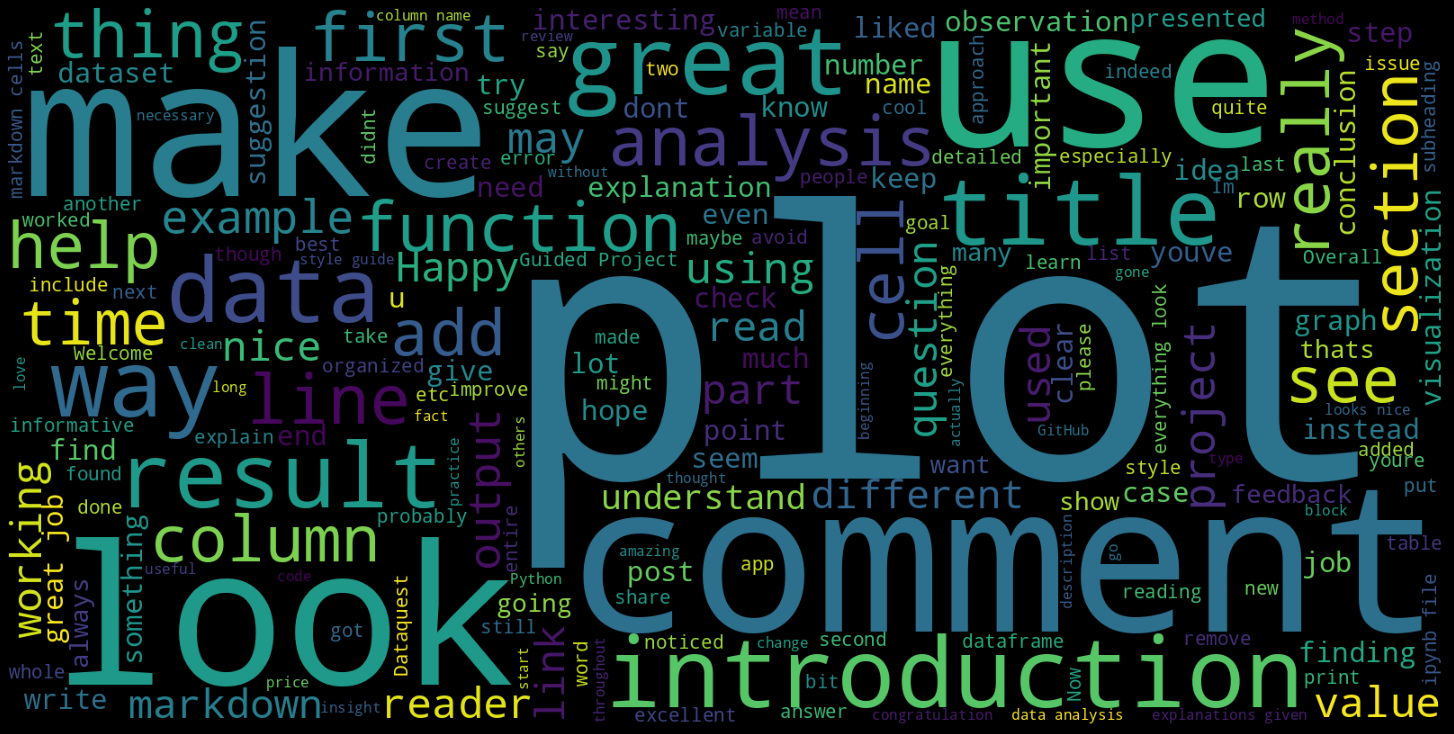

In [13]:
stopwords1 = list(STOPWORDS) 
more_stopwords = ['also', 'it', 'thank', 'think', 'one', 'thanks']
stopwords2 = stopwords1+more_stopwords

text =  str(df['top15_removed'].sum())
text = text.replace("'","")
wordcloud = WordCloud(width=1600, height=800, stopwords=stopwords2)
wordcloud.generate(text)
# Open a plot of the generated image.

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<a id='ml'></a>

# 4. Supervised machine learning
[back to top](#index)

We'll try to apply a few simple machine learning models to analyze and classify the n-grams. In the first attempt we'll try to train our model in recognizing whether the n-gram is a helpful advice or not. In the previous steps of EDA, we've removed stopwords, so not all of the n-grams make sense anymore. To create a training set, we'll manually mark a small set of n-grams with a 0 (not helpful) or 1 (helpful). 

In [14]:
learn_tri = trigrams[['trigram', 'count']]

# manualy mark whether the trigram is helpful or not:
list20 = [0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,0,1,0,1]
list20_40 = [1,0,1,1,0,1,0,0,0,1,1,0,1,1,1,1,1,1,1,1]
list40_60 = [1,0,1,0,1,1,1,0,1,0,0,1,1,0,0,0,0,0,1,1]
list60_80 = [1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0]

# create a train set and test set:
train = learn_tri[:80].copy()
test = learn_tri[80:].copy()

train['trigram'] = train['trigram'].str.join(',').str.lower().str.replace(',',' ')
test['trigram'] = test['trigram'].str.join(',').str.lower().str.replace(',',' ')

# mark the rows with the value helpful or not:
list_helpful = list20+list20_40+list40_60+list60_80
train['helpful'] = list_helpful
train

,trigram,count,helpful
15,get help youd,27,0
64,make projects professional,14,1
105,consider rerunning sequential,10,1
155,use technical word,9,1
210,use uniform style,7,1
...,...,...,...
4421,use jupyter lab,1,1
4448,get moment hope,1,0
4516,use jupyter labnotebook,1,1
4710,use headings subheadings,1,1


In [15]:
# import the ML libraries:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# preprocess data:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train['trigram'].values)
X = tokenizer.texts_to_sequences(train['trigram'].values)
X = pad_sequences(X)
Y = tokenizer.texts_to_sequences(test['trigram'].values)
Y = pad_sequences(Y)

# split dataset:
X_train = X
y_train = train['helpful']
X_test = Y

def fit_model(model):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# create models:
model1 = KNeighborsClassifier(n_neighbors = 1)
model2 = RandomForestClassifier()
model3 = GaussianNB()
model4 = ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_features=0.55, min_samples_leaf=8, min_samples_split=4, n_estimators=100) # Optimized using TPOT
model5 = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1)

# fit models:
test['KNeighbors'] = fit_model(model1)
test['RandomForest'] = fit_model(model2)
test['GaussianNB'] = fit_model(model3)
test['ExtraTree'] = fit_model(model4)
test['MLP'] = fit_model(model5)
test[:20].style.background_gradient(cmap='Blues')

,trigram,count,KNeighbors,RandomForest,GaussianNB,ExtraTree,MLP
4857,make kindly recheck,1,1,1,1,1,1
4892,make bit large,1,1,1,1,1,1
4916,make need something,1,1,1,1,1,1
4957,make otherwise congratulations,1,1,1,1,1,1
5090,use 1 line,1,1,1,1,1,0
5134,make bit professional,1,1,1,1,1,1
5206,make projects choices,1,1,1,1,1,1
5254,use docstring thats,1,1,1,1,1,0
5282,get important data,1,1,1,1,1,1
5331,get honestly looks,1,1,1,1,1,1


Looks like most of the models flooded the results with a single value.

### Check value counts:

In [16]:
for col in test.columns[2:]:
    print(test[col].value_counts())

1    736
0     21
Name: KNeighbors, dtype: int64
1    733
0     24
Name: RandomForest, dtype: int64
1    732
0     25
Name: GaussianNB, dtype: int64
1    757
Name: ExtraTree, dtype: int64
1    580
0    177
Name: MLP, dtype: int64


In [17]:
test = test[['trigram', 'count', 'MLP']].copy()
test[:20].style.background_gradient(cmap='Blues')

,trigram,count,MLP
4857,make kindly recheck,1,1
4892,make bit large,1,1
4916,make need something,1,1
4957,make otherwise congratulations,1,1
5090,use 1 line,1,0
5134,make bit professional,1,1
5206,make projects choices,1,1
5254,use docstring thats,1,0
5282,get important data,1,1
5331,get honestly looks,1,1


All of the models failed at any classification attempt. It's worth noting though that the MLP is the only model which hasn't assigned only 1 value to an overwhelming majority of rows. We'll try improving that model.

### Apply gridsearch for hyperparameter tuning
(btw this was supposed to be an easy EDA project to catch a break from ML)

In [18]:
mlp = MLPClassifier(max_iter=3000, random_state=0)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)
print(clf.best_params_)

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}


## Apply best hyperparameters: 

In [19]:
model6 = MLPClassifier(activation = "tanh", alpha = 0.0001, hidden_layer_sizes = (50, 50, 50),
                            learning_rate = "constant", max_iter = 2000, random_state = 1, solver='sgd')

test['MLP_v2'] = fit_model(model5)

# check if there's any diffrence in predictions:
test[test['MLP_v2'] != test['MLP']]

,trigram,count,MLP,MLP_v2


Even though MLP model stands out in comparison to other classifiers, it still fails do deliver any significant results on our initial tests. It's no surprise: we've fed the model with a very small training set and our text preprocessing was basic. In essence: **Garbage in, garbage out**. 

<a id='cluster'></a>

# 5. Kmeans clustering
[back to top](#index)

In [20]:
trigrams['trigram'] = trigrams['trigram'].str.join(',').str.lower().str.replace(',',' ')

# vectorize text:
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(trigrams['trigram']).toarray()

# fit and label:
Kmean = KMeans(n_clusters=3)
Kmean.fit(X)
trigrams['label'] = Kmean.labels_

In [21]:
trigrams[trigrams['label'] == 0][:10]

,trigram,count,label
15,get help youd,27,0
105,consider rerunning sequential,10,0
275,consider creating function,6,0
282,make always consider,6,0
420,consider rounding outputs,4,0
559,consider rounding output,3,0
789,consider using forloop,3,0
1057,consider creating functions,2,0
1256,consider adding link,2,0
1409,consider defining function,2,0


In [22]:
trigrams[trigrams['label'] == 1][:10]

,trigram,count,label
155,use technical word,9,1
210,use uniform style,7,1
214,use uniform quote,7,1
272,use comments explanations,6,1
466,use type a,4,1
698,use markdown comments,3,1
817,use markdown cells,3,1
854,use either equals,3,1
1026,use comments explanation,2,1
1207,use seaborn library,2,1


In [23]:
trigrams[trigrams['label'] == 2][:10]

,trigram,count,label
64,make projects professional,14,2
610,make easier read,3,2
945,make plot titles,2,2
948,make hardly used,2,2
1067,make think ought,2,2
1342,make havent included,2,2
1419,make much easier,2,2
1576,make interesting happy,2,2
1831,make your projects,2,2
2115,make even it,2,2


We can notice that Kmeans clustered most of the trigrams using the first word as decisive factor. Increasing the amount of clusters should lead to the model splitting the rows based on the second word at some point. Lets check if that will work:

In [24]:
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))  
X = tfidfconverter.fit_transform(trigrams['trigram']).toarray()

# fit and label:
Kmean = KMeans(n_clusters=9)
Kmean.fit(X)
trigrams['label'] = Kmean.labels_
trigrams

,trigram,count,label
15,get help youd,27,4
64,make projects professional,14,6
105,consider rerunning sequential,10,0
155,use technical word,9,2
210,use uniform style,7,2
...,...,...,...
58807,make resumeready may,1,1
58863,get sense complete,1,6
58954,make easier fit,1,6
59153,get explain im,1,4


In [25]:
trigrams[trigrams['label'] == 0][:10]

,trigram,count,label
105,consider rerunning sequential,10,0
420,consider rounding outputs,4,0
1057,consider creating functions,2,0
1256,consider adding link,2,0
2587,consider adding introduction,2,0
3151,consider leaving space,1,0
3671,consider adding empty,1,0
5715,consider giving explanations,1,0
7182,consider adding text,1,0
8392,consider remove 108,1,0


In [26]:
trigrams[trigrams['label'] == 7][:10]

,trigram,count,label
272,use comments explanations,6,7
698,use markdown comments,3,7
1026,use comments explanation,2,7
1682,use comments presented,2,7
1877,use comments markdown,2,7
7821,use use comments,1,7
7822,use comments docstrings,1,7
8108,use comments know,1,7
9206,use comments this,1,7
9447,use comments informing,1,7


Now we can observe 2 clusters that start with the word 'use', but one of them is purely about comments!

<a id='conclusions'></a>

# 6. Conclusions:
[back to top](#index)

Even though we've just scratched the surface of natural language processing, we've already achieved promising results. Extracting most popular n-grams seems to be the easiest approach for a basic NLP approach, we should try it out with stopwords included. 

Unsupervised learning delivered satisfactory results on our dataset of n-grams. The only disappointment was lack of significant results in our supervised learning attempts, it was expected though. Our preparation process was minimal. 

During this project I came across and tried multiple NLP libraries and it would be hard to name all of them, but they're out there - ready to use.

Lets recall the top 10 most popular trigrams and 4-grams:

In [27]:
top10_f4_grams

,qgram,count
69,"(consider, rerunning, sequential, ordering)",10
113,"(use, technical, word, documentation)",9
139,"(use, uniform, style, quote)",7
143,"(make, Projects, Professional, Social)",7
292,"(use, type, A, successful)",4
300,"(use, uniform, quote, mark)",4
335,"(consider, rounding, output, values)",3
340,"(use, comments, explanations, given)",3
364,"(consider, rounding, outputs, cells)",3
375,"(make, Always, consider, rerunning)",3


In [28]:
top10_trigrams

,trigram,count
15,get help youd,27
64,make projects professional,14
105,consider rerunning sequential,10
155,use technical word,9
210,use uniform style,7
214,use uniform quote,7
272,use comments explanations,6
275,consider creating function,6
282,make always consider,6
420,consider rounding outputs,4
